# Determine the sample size for estimation

You can use this notebook to evaluate the accuracy of the selection coefficient estimator for:
- Difference selection coefficients
- Any demographic scenario
- Different allele frequencies
- Different sample sizes
- Different cM length thresholds
- Different genic selection models (additive vs. dominance)

In general, the sample size required will depend on:
- Different cM length threshold (fewer samples required, but hard to infer in real data)
- Demographic scenario (fewer samples required, but more variance)
- Selection coefficient (fewer samples required, but s >= 0.05 unlikely in many species)

You can modify the for loops to explore different:
- Sweeping allele frequencies
- cM length thresholds
- Demographic scenarios

We show the former two in our paper.

In [1]:
from isweep import *
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',size=16)

### Set up the defaults

In [2]:
ss = [0.01,0.02,0.03,0.04] # selection coefficients
p = 0.5 # allele frequency
Ne = read_Ne('constant-10k.ne') # population size

long_length = 3. # cM threshold for selection coefficient estimation
short_length = long_length
model = 'a' # additive

### Explore different sample sizes

Make a list in the following code block.

You loop over these sample sizes for different coefficients.

You then evaluate point estimates change as sample size changes.

Expect the second code block to run for a few minutes. 

If sample size <= 2000, this analysis should be reasonable for a personal laptop.

In [3]:
# choose sample size
ns = [50,100,200,400]

K = 100 # number of simulations for each sample size + selection coefficient

In [4]:
n = ns[0]
selests = []
truths = []
m = (2 * n)
M = m * (m-1) / 2 - m
for i in range(len(ss)):
    s = ss[i]
    # print(s)
    for k in range(K):
        out = simulate_ibd_isweep(n,s,p,Ne,long_length,short_length,one_step_model=model)
        numibd = out[0][0]
        sol = minimize_scalar(chi2_isweep,
                        args=(p,Ne,M,(numibd,),(long_length,np.inf),model,0,-0.01,2),
                        bounds=(0,0.5),
                        method='bounded'
                       )
        est = sol.x
        selests.append(est)
        truths.append(s)
datatable = dict()
datatable['truth'] = truths
datatable['estimate'] = selests
table = pd.DataFrame(datatable)
table['sample_size'] = n


for n in ns[1:]:
    selests = []
    truths = []
    m = (2 * n)
    M = m * (m-1) / 2 - m
    print(n)
    for i in range(len(ss)):
        s = ss[i]
        # print(s)
        for k in range(K):
            out = simulate_ibd_isweep(n,s,p,Ne,long_length,short_length,one_step_model=model)
            numibd = out[0][0]
            sol = minimize_scalar(chi2_isweep,
                            args=(p,Ne,M,(numibd,),(long_length,np.inf),model,0,-0.01,2),
                            bounds=(0,0.5),
                            method='bounded'
                           )
            est = sol.x
            selests.append(est)
            truths.append(s)
    datatable = dict()
    datatable['truth'] = truths
    datatable['estimate'] = selests
    table1 = pd.DataFrame(datatable)
    table1['sample_size'] = n
    table = pd.concat((table,table1))
table.head()

100
200
400


,truth,estimate,sample_size
0,0.01,0.005193,50
1,0.01,0.039997,50
2,0.01,0.000005,50
3,0.01,0.020781,50
4,0.01,0.000005,50


## Plotting the results

Now, we graphically consider the results. Below we show a boxplot.

As sample size increases, the selection coefficient point estimates get closer to the truth.
- The average estimate is close to the truth
- The variance of point estimates decreases

Note that estimating s <= 0.01 is difficult.

In [5]:
yupp = 0.08 # upper bound on y-axis
ylow = -0.005 # lower bound on y-axis

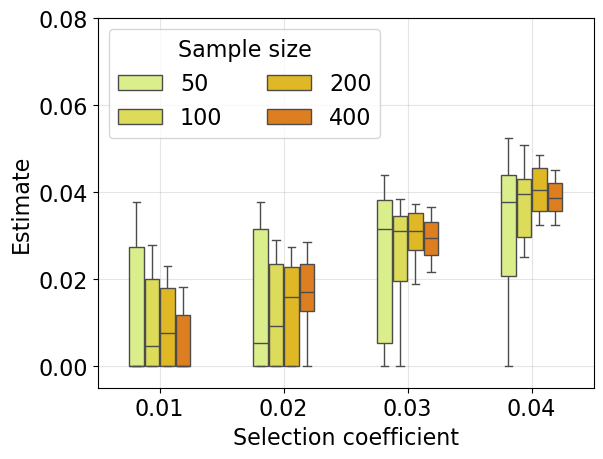

In [6]:
sns.boxplot(data=table,
              x='truth',
              y='estimate',
              hue='sample_size',
              palette='Wistia',
              showfliers=False,
                whis=[10,90],
            width=0.5,
            gap=0.05,
            fliersize=1,
             )

plt.legend(loc='upper left',
           title='Sample size',
           ncol=2
          )
plt.ylim(ylow,yupp)
plt.xlabel('Selection coefficient')
plt.ylabel('Estimate')
plt.grid(alpha=0.33)